In [2]:
def predict_stock():
    import yfinance as yf
    import pandas as pd
    import os

    if os.path.exists("sp500.csv"):
        sp500 = pd.read_csv("sp500.csv", index_col=0)
    else:
        sp500 = yf.Ticker("^GSPC")
        sp500 = sp500.history(period="max")
        sp500.to_csv("sp500.csv")
        
    sp500.index = pd.to_datetime(sp500.index)

    sp500

    sp500.plot.line(y="Close", use_index=True)

    del sp500["Dividends"]
    del sp500["Stock Splits"]

    sp500["Tomorrow"] = sp500["Close"].shift(-1)

    sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

    sp500 = sp500.loc["1990-01-01":].copy()

    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

    train = sp500.iloc[:-100]
    test = sp500.iloc[-100:]

    predictors = ["Close", "Volume", "Open", "High", "Low"]
    model.fit(train[predictors], train["Target"])

    from sklearn.metrics import precision_score

    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision_score(test["Target"], preds)

    combined = pd.concat([test["Target"], preds], axis=1)
    combined.plot()

    def predict(train, test, predictors, model):
        model.fit(train[predictors], train["Target"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index, name="Predictions")
        combined = pd.concat([test["Target"], preds], axis=1)
        return combined


    def backtest(data, model, predictors, start=2500, step=250):
        all_predictions = []

        for i in range(start, data.shape[0], step):
            train = data.iloc[0:i].copy()
            test = data.iloc[i:(i+step)].copy()
            predictions = predict(train, test, predictors, model)
            all_predictions.append(predictions)
        
        return pd.concat(all_predictions)


    predictions = backtest(sp500, model, predictors)

    predictions["Predictions"].value_counts()

    precision_score(predictions["Target"], predictions["Predictions"])

    predictions["Target"].value_counts() / predictions.shape[0]

    horizons = [2,5,60,250,1000]
    new_predictors = []

    for horizon in horizons:
        rolling_averages = sp500.rolling(horizon).mean()
        
        ratio_column = f"Close_Ratio_{horizon}"
        sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
        
        trend_column = f"Trend_{horizon}"
        sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
        
        new_predictors+= [ratio_column, trend_column]
        
        
    sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

    sp500

    model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

    def predict(train, test, predictors, model):
        model.fit(train[predictors], train["Target"])
        preds = model.predict_proba(test[predictors])[:,1]
        preds[preds >=.6] = 1
        preds[preds <.6] = 0
        preds = pd.Series(preds, index=test.index, name="Predictions")
        combined = pd.concat([test["Target"], preds], axis=1)
        return combined


    predictions = backtest(sp500, model, new_predictors)

    predictions["Predictions"].value_counts()

    precision_score(predictions["Target"], predictions["Predictions"])

    predictions["Target"].value_counts() / predictions.shape[0]

    predictions

/usr/local/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


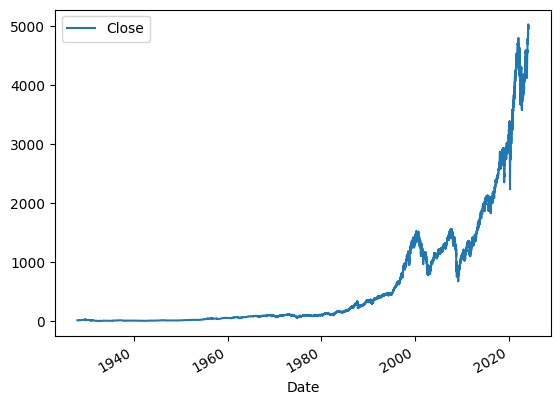

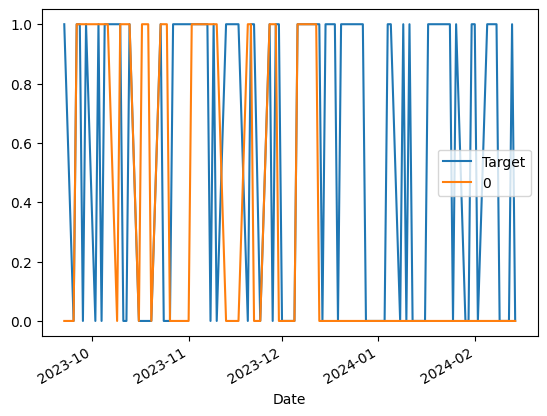

In [3]:
predict_stock()